In [1]:
%matplotlib inline
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np # linear algebra
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os


In [2]:
df=pd.read_csv('SAheart.data', sep=",")

In [3]:
X = df[['age','ldl']].values
y = df.chd.values

In [4]:
# Define the max-min normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

# Define the mean-std normalized function
def mean_std_normalized(data):
    col_mean = np.mean(data, axis=0)
    col_std = np.std(data, axis=0)
    return np.divide(data - col_mean, col_std)

# Definition of the weights of evidence w_j = beta_j*phi(x)+alpha_j, refer to Equ.16 in paper NNBelief
def trained_weight(A,b,X):  
    weights= np.empty((len(X.index), len(A)))
    for i in range(len(A)):
        weights[:,[i]]= np.array([X[i]*A[i]+b]).T
    return weights 

# Calculate positive & negative weights of evidence (w^+,w^-，参见Equ.16下面那段描述)
def weight_of_evidence(weight):
    W=[]
    if isinstance(weight[0],list):
        for i in range(len(weight)):
            W.append((max(0,weight[i][0]),max(0,-weight[i][0])))
    else:
        for i in range(len(weight)):
            W.append((max(0,weight[i]),max(0,-weight[i])))        
    return W

# Calculate the sum of positive & negative weights (参见Equ.17下面一行公式)
def sum_weight(W):
    weight_pos_temp = np.empty((W.shape[0], W.shape[1]))
    weight_neg_temp = np.empty((W.shape[0], W.shape[1]))
    weight_pos = np.empty((W.shape[0], 1))
    weight_neg = np.empty((W.shape[0], 1))
    for i in range(W.shape[1]):
        weight_pos_temp[:,[i]]=np.array(weight_of_evidence(W[:,[i]]))[:,[0]]
        weight_neg_temp[:,[i]]=np.array(weight_of_evidence(W[:,[i]]))[:,[1]]
    weight_pos=np.sum(weight_pos_temp,axis=1)
    weight_neg=np.sum(weight_neg_temp,axis=1)
    return(weight_pos,weight_neg)

# Definition of the degree of conflict k=[1-exp(-w^+)]*[1-exp(-w^-)] (Equ.21c)
def degree_of_conflict(W_pos,W_neg):
    k=(1-np.exp(-1*W_pos))*(1-np.exp(-1*W_neg))
    return k

# Calculate conflict from trained parameters and feature values
def conflict(A,b,X):
    w_j=trained_weight(A,b,X)   
    weight_pos,weight_neg=sum_weight(w_j)
    k=degree_of_conflict(weight_pos,weight_neg)
    return k



In [5]:

ldl = np.arange(0,15,0.3)
age = np.arange(0,70,1.4)

ldl_norm=mean_std_normalized(ldl)
age_norm=mean_std_normalized(age)

#将原始数据变成网格数据形式
X,Y = np.meshgrid(age_norm,ldl_norm)

In [6]:
beta= [[0.5974239], [0.3825687]]

In [7]:
alpha= [-0.36972204]

In [8]:
kk=conflict(beta,alpha,pd.DataFrame({0:(X.flatten()),1:(Y.flatten())})).reshape(50,50)

Text(0.5,1,u'degree of conflict')

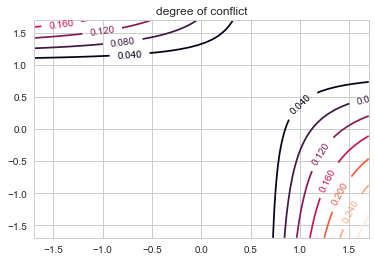

In [9]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, kk)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('degree of conflict')